in this notebook we:
* using full images (576, 768) - take the model from stage 4a, and inspect it using grad-CAM method (https://arxiv.org/abs/1610.02391) (code adapted from https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai)
* compute csv with results of the model on the validation set
 * run first checks on those

In [1]:
# imports for the plot_heatmap_overview function
from random import randint
import cv2
from fastai.callbacks.hooks import *

In [75]:
from PIL import Image

In [2]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb_no_rescale import *
# from functions_wandb import *

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [5]:
len(df.uniqueName)

347120

In [6]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [7]:
# df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
# df.head()

In [8]:
# model = "stage4a-intermediate_bestmodel.pkl"
# learn = load_learner(PATH_TO_MODELS, model)#, test=df.uniqueName)

In [9]:
data = get_training_data(df, (576, 768), batch_size=32)#, partial_pct=0.01)

In [10]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage4a-intermediate_bestmodel");

In [11]:
learn.callback_fns = [learn.callback_fns[0]]

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

In [20]:
# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learn.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes:list):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,14))
    fig.suptitle('Predicted / Actual\nLoss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='bwr')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='bwr')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='bwr')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
    
# Added a bit of random factor to the most good and bad
def plot_heatmap_overview_randomized(interp:ClassificationInterpretation, classes:list):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,14))
    fig.suptitle('Predicted / Actual\nLoss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='coolwarm')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses (among 100 of them)
    for i in range(4):
        idx = tl_idx[i + randint(0,100)]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='coolwarm')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples\n(among 100)', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses (among 100 of them)
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1 - randint(0,100)]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,W,H,0),
              interpolation='bilinear', cmap='coolwarm')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]}\n{interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples\n(among 100)', fontsize=16, rotation=0, labelpad=80)

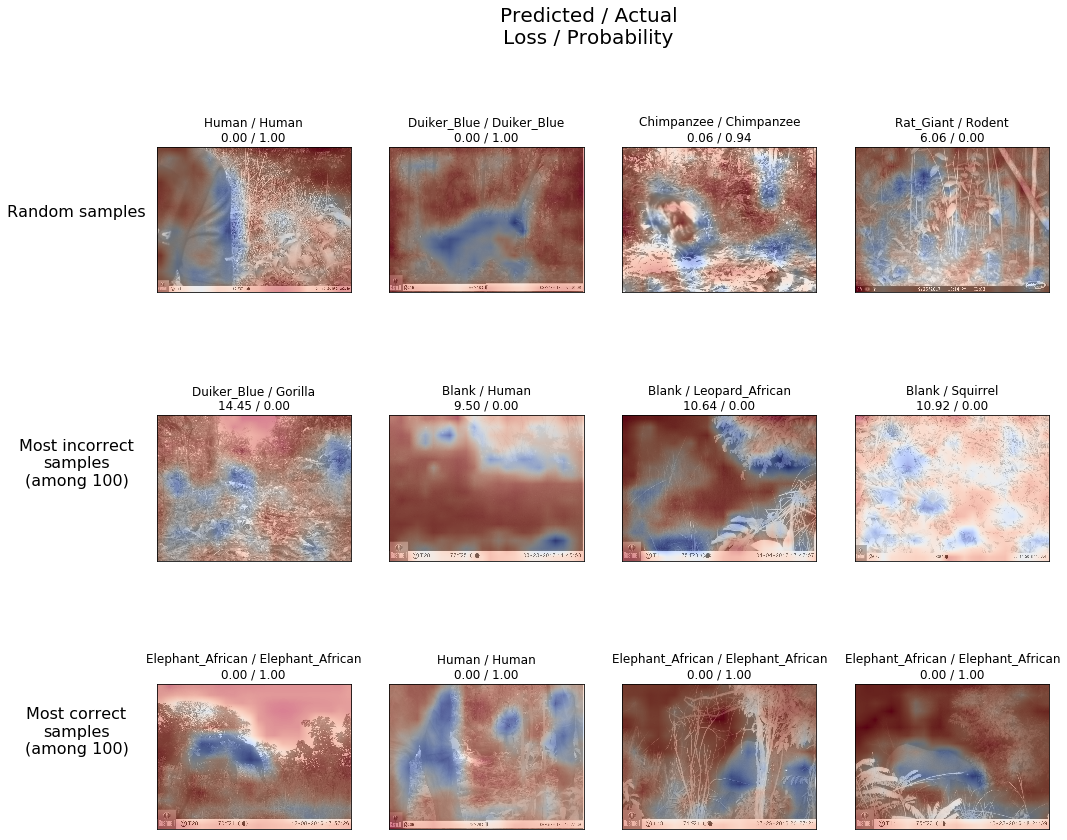

In [62]:
imgDataBunch = data

plot_heatmap_overview_randomized(interp, sorted(classes))

In [68]:
sorted_classes = sorted(classes)
labels = [sorted_classes[x] for x in interp.y_true]
preds = [sorted_classes[x] for x in interp.preds.argmax(axis=1)]
losses = list(interp.losses.numpy())
paths = list(interp.ds.x.items)

In [69]:
print(f"Accuracy is {round(100 * sum([l == p for (l,p) in zip(labels,preds)]) / len(preds), 2)}%")

Accuracy is 80.49%


In [71]:
results = pd.DataFrame({"path": paths,
                        "label": labels,
                        "pred": preds,
                        "loss": losses}
                      )
results["path_rescaled"] = results.path.str.replace("/Gabon_trainingData/", "_rescaled/resc_")
results.head()

,path,label,pred,loss,path_rescaled
0,/data/Gabon_trainingData/1039759.jpg,Human,Human,0.005454,/data_rescaled/resc_1039759.jpg
1,/data/Gabon_trainingData/1195784.jpg,Porcupine_Brush_Tailed,Porcupine_Brush_Tailed,0.001567,/data_rescaled/resc_1195784.jpg
2,/data/Gabon_trainingData/0880576.jpg,Blank,Blank,0.001649,/data_rescaled/resc_0880576.jpg
3,/data/Gabon_trainingData/1194852.jpg,Monkey,Blank,6.132198,/data_rescaled/resc_1194852.jpg
4,/data/Gabon_trainingData/1201480.jpg,Hog_Red_River,Duiker_Blue,5.312629,/data_rescaled/resc_1201480.jpg


In [84]:
# results.to_csv("results_4a_on_valid_label_pred_loss.csv")

In [83]:
# Image.open(results.path_rescaled[4])

# Where is the biggest loss

Idea: plot conf_m but with color given by
* sum of losses for that pred/label pair
* avg losses for that pred/label pair


In [88]:
results.groupby("label")["loss"].sum().sort_values()

label
Rail_Nkulengu               51.847702
Civet_African_Palm         100.991913
Genet                      176.145039
Cat_Golden                 210.725621
Mongoose_Black_Footed      226.164377
Guineafowl_Crested         232.402840
Guineafowl_Black           275.768987
Pangolin                   330.660274
Buffalo_African            506.489288
Bird                       575.855108
Mongoose                   593.549775
Leopard_African            648.045105
Rodent                     792.104572
Human                      798.159288
Chevrotain_Water           941.763251
Porcupine_Brush_Tailed     969.058576
Elephant_African          1064.195581
Duiker_Yellow_Backed      1147.442984
Chimpanzee                1321.428468
Gorilla                   1539.940902
Blank                     1717.296466
Hog_Red_River             1730.696170
Duiker_Red                1852.306515
Squirrel                  1861.271652
Duiker_Blue               2153.999308
Monkey                    2282.488678
Rat_Gi

In [90]:
results.groupby("label")["loss"].mean().sort_values()

label
Human                     0.159632
Elephant_African          0.212839
Blank                     0.343459
Duiker_Red                0.370461
Duiker_Blue               0.430800
Hog_Red_River             0.489035
Genet                     0.541985
Bird                      0.830960
Guineafowl_Black          0.889577
Rat_Giant                 0.992340
Leopard_African           1.001615
Buffalo_African           1.048632
Duiker_Yellow_Backed      1.052700
Porcupine_Brush_Tailed    1.071967
Chimpanzee                1.230380
Mongoose_Black_Footed     1.379051
Civet_African_Palm        1.655605
Mandrillus                1.663716
Mongoose                  1.831944
Gorilla                   2.144764
Monkey                    2.226818
Rodent                    2.343505
Chevrotain_Water          2.378190
Squirrel                  2.436219
Pangolin                  2.505002
Cat_Golden                2.809675
Guineafowl_Crested        3.521255
Rail_Nkulengu             8.641284
Name: loss, dt

In [91]:
results[results.label != results.pred].groupby("label")["loss"].mean().sort_values()

label
Guineafowl_Black          2.235881
Duiker_Blue               2.610241
Gorilla                   2.611514
Rat_Giant                 2.734183
Mandrillus                2.879103
Blank                     3.030787
Hog_Red_River             3.093271
Chimpanzee                3.155156
Duiker_Red                3.177320
Human                     3.195477
Elephant_African          3.233742
Bird                      3.432875
Civet_African_Palm        3.444248
Buffalo_African           3.463108
Genet                     3.483285
Rodent                    3.512425
Porcupine_Brush_Tailed    3.609312
Duiker_Yellow_Backed      3.620310
Chevrotain_Water          3.949215
Mongoose                  4.268791
Mongoose_Black_Footed     4.309178
Cat_Golden                4.516813
Guineafowl_Crested        4.533768
Monkey                    4.562185
Squirrel                  4.756529
Leopard_African           5.043197
Pangolin                  5.110404
Rail_Nkulengu             8.641284
Name: loss, dt

In [92]:
results[results.label == results.pred].groupby("label")["loss"].mean().sort_values()

label
Human                     0.023888
Elephant_African          0.037019
Leopard_African           0.043382
Blank                     0.056763
Genet                     0.069276
Duiker_Red                0.071013
Hog_Red_River             0.080394
Mongoose_Black_Footed     0.093908
Duiker_Blue               0.095888
Bird                      0.099922
Civet_African_Palm        0.137969
Porcupine_Brush_Tailed    0.139177
Duiker_Yellow_Backed      0.139346
Buffalo_African           0.150063
Monkey                    0.153804
Guineafowl_Black          0.169771
Pangolin                  0.197361
Mongoose                  0.199005
Chevrotain_Water          0.201469
Squirrel                  0.211102
Chimpanzee                0.227098
Cat_Golden                0.248969
Rodent                    0.273940
Mandrillus                0.282190
Rat_Giant                 0.290149
Guineafowl_Crested        0.357152
Gorilla                   0.449410
Name: loss, dtype: float64